In [ ]:
#install OSMNX
!apt install libspatialindex-dev
!pip install rtree
!pip install osmnx
!pip install networkx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (435 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

In [ ]:
#import libraries and mount drive with data
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#import data as CSV
data = pd.read_csv("/content/drive/My Drive/CS221 Final Project/CS221_Project_Dataset.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Clean our Dataset
data.dropna(axis=0)
data = data.loc[data['RiskLevel'] != ' ']
Clean = data[['DayOfWeek','Date','Time','X','Y','RiskLevel', 'Location', 'Address']]
Clean['Date'] = pd.to_datetime(Clean['Date'], infer_datetime_format=True)
Clean = Clean.loc[Clean['Date'] >= pd.to_datetime("2017-01-01", infer_datetime_format=True)]
Clean['Month'] = pd.DatetimeIndex(Clean['Date']).month
Clean['Time'] = pd.to_datetime(Clean['Time'], infer_datetime_format=True)
Clean['Time'] = pd.DatetimeIndex(Clean['Time']).time
Clean['Seconds'] = Clean['Time'].apply(lambda t: (t.hour * 60 + t.minute) * 60 + t.second)
Clean['X'] = Clean['X'].apply(lambda x: float(x))
Clean['Y'] = Clean['Y'].apply(lambda y: float(y))
Clean['RiskLevel'] = Clean['RiskLevel'].apply(lambda x: int(x))
Clean['xcart'] = np.cos(Clean['Y']) * np.cos(Clean['X']) * (6378137.0 + 16)
Clean['ycart'] = np.cos(Clean['Y']) * np.sin(Clean['X']) * (6378137.0 + 16)
Clean

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,DayOfWeek,Date,Time,X,Y,RiskLevel,Location,Address,Month,Seconds,xcart,ycart
362,5,2017-02-16,15:00:00,-122.456617,37.737895,4,POINT (-122.45661719059865 37.737895076045305),100 Block of DALEWOOD WY,2,54000,-6.359692e+06,-417132.901254
363,2,2017-02-06,11:27:00,-122.457869,37.739576,3,POINT (-122.45786900682154 37.73957649446974),200 Block of JUANITA WY,2,41220,-6.359785e+06,-409144.137236
372,5,2018-02-01,15:00:00,-122.457869,37.739576,2,POINT (-122.45786900682154 37.73957649446974),200 Block of JUANITA WY,2,54000,-6.359785e+06,-409144.137236
379,7,2017-03-11,13:00:00,-122.456617,37.737895,4,POINT (-122.45661719059865 37.737895076045305),0 Block of DALEWOOD WY,3,46800,-6.359692e+06,-417132.901254
387,6,2018-03-30,09:30:00,-122.461277,37.739042,2,POINT (-122.46127656933086 37.739041695719145),0 Block of MIRALOMA DR,3,34200,-6.361279e+06,-387478.773718
...,...,...,...,...,...,...,...,...,...,...,...,...
2212274,6,2017-03-24,13:40:00,-122.424582,37.769733,4,POINT (-122.42458205493489 37.769733212432136),GUERRERO ST / DUBOCE AV,3,49200,-6.332018e+06,-619536.507360
2212275,6,2017-03-24,18:00:00,-122.422367,37.769868,4,POINT (-122.42236740956325 37.76986823924552),DUBOCE AV / VALENCIA ST,3,64800,-6.330570e+06,-633552.094451
2212276,1,2017-04-16,12:20:00,-122.448043,37.782371,4,POINT (-122.44804312445392 37.78237103548864),GEARY BL / MASONIC AV,4,44400,-6.338631e+06,-470365.219287
2212277,6,2017-02-03,15:20:00,-122.448043,37.782371,5,POINT (-122.44804312445392 37.78237103548864),MASONIC AV / GEARY BL,2,55200,-6.338631e+06,-470365.219287


In [ ]:
#Create Graph of all of SF
G = ox.graph_from_place('San Francisco, California, USA', network_type='walk', simplify=True)

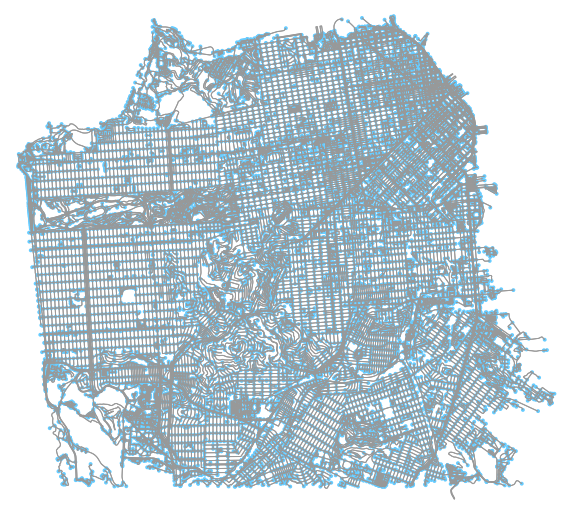

In [ ]:
#Plot Graph of SF
fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10)

In [ ]:
#A funciton that converts lon/lat points into cartesian points
def getCartesian(tup):
  return(np.cos(tup[0]) * np.cos(tup[1]) * (6378137.0 + 16),np.cos(tup[0]) * np.sin(tup[1]) * (6378137.0 + 16))

In [ ]:
#constructing a graph around the centerpoint of a given origin and destination to limit the area searched(for speeeeeeed)
start = (37.805998, -122.410346) #(37.792867,-122.402697)
end = (37.785577, -122.396806) #(37.776302,-122.40208)
#north = max([start[0], end[0]]) + np.abs(start[1] - end[1])/2
#south = min([start[0], end[0]]) - np.abs(start[1] - end[1])/2
#east = max([start[1], end[1]]) + np.abs(start[0] - end[0])/2
#west = min([start[1], end[1]]) - np.abs(start[0] - end[0])/2
#Search = ox.graph_from_bbox(north,south,east,west,simplify=True,network_type='walk')
#fig, ax = ox.plot_graph(Search, fig_height=10, fig_width=10)

In [ ]:
#Create the origin node and Destination node form our start and end cordinates
origin = ox.get_nearest_node(G, (start), method='euclidean')
destination = ox.get_nearest_node(G, (end), method='euclidean')
edges = G.edges(keys = True)

In [ ]:
#Checks if a point is in a given ellipse
def inEllipse(xT,yT,cx,cy,theta, a, b):
  if np.abs(xT - cx) > np.abs(yT-cy):
    return (((yT - cy)*np.cos(theta) - (xT - cx)*np.sin(theta))**2)/a + (((yT - cy)*np.sin(theta) + (xT - cx)*np.cos(theta))**2)/b <= 1
  else: 
    return (((yT - cy)*np.cos(theta) - (xT - cx)*np.sin(theta))**2)/b + (((yT - cy)*np.sin(theta) + (xT - cx)*np.cos(theta))**2)/a <= 1

In [ ]:
#Sets the weights of an edge based on the crimes that fall within an elliptical shape around the street with the intersections as the foci
def radialRisk(tup):
  #Convert to Cartesian and derive angle
  x1, y1 = getCartesian((G.nodes[tup[0]]['y'], G.nodes[tup[0]]['x']))
  x2, y2 = getCartesian((G.nodes[tup[1]]['y'], G.nodes[tup[1]]['x']))
  theta = np.arctan((y2-y1)/(x2-x1))
  dist = ox.distance.euclidean_dist_vec(y1, x1, y2, x2)

  #find the center point
  cx = (x1+x2)/2
  cy = (y1+y2)/2

  #intialize constants and variables
  b = (110)**2
  a = (ox.distance.euclidean_dist_vec(y1, x1, y2, x2)/2)**2 + b
  street_risk = 0
  num_on_street = .1**10

  #Limit the space of crimes in which we search to a square shape around the street of interest
  crimes = Clean.loc[(cx-(dist/2) <= Clean['X']) & (Clean['xcart'] <= cx+(dist/2)) & (cy-(dist/2) <= Clean['ycart']) & (Clean['ycart'] <= cy+(dist/2))]

  #iterate through all crimes in the area and check if they contribute to the risk level of the street
  for index, crime in crimes.iterrows():
      xTrain = crime['xcart']
      yTrain = crime['ycart']
      if inEllipse(xTrain, yTrain, cx, cy, theta, a, b):
        street_risk += crime['RiskLevel']
        num_on_street += 1

  #set the risk level as the mean of the crimes in the elliptical area
  return street_risk/num_on_street

In [ ]:
#Uses the above functions to set the weigts of the edges
#Warning --- This will take 1hr & 30min
#just skip to cell fifty an load in saved graph
newWeight = {(edge):{'risk3': radialRisk(edge)} for edge in edges}
nx.set_edge_attributes(G, newWeight)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
#Use KNN to classify the risk level of streets - Creating the KNN model
KNN = KNeighborsClassifier(20)
KNN.fit(Clean[['X','Y']], Clean['RiskLevel'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [ ]:
#Assigns risk value to edges based on KNN of starting node
def riskValue(tup):
  x = tup[0]
  y = tup[1]
  temp = pd.DataFrame({'X':G.nodes[x]['x'], 'Y': G.nodes[y]['y']}, index=[0])
  RiskLevel = KNN.predict(temp)
  return RiskLevel

  

In [ ]:
#Assigns new weights using the above functions
newWeight = {(edge):{'risk': riskValue(edge)} for edge in edges}
nx.set_edge_attributes(G, newWeight)

In [ ]:
#save graph to google drive
ox.io.save_graphml(G, filepath="/content/drive/My Drive/CS221 Final Project/Final_graph.graphml")

In [ ]:
#upload saved graph and convert weights to proper types
G = ox.io.load_graphml('/content/drive/My Drive/CS221 Final Project/Final_graph.graphml')
edges = G.edges(keys = True)
for edge in edges:
  edges[edge]['risk'] = float(edges[edge]['risk'])
  #Sets roads with no crime data to high number to dicourage 
  #going down paths we know nothing about 
  if edges[edge]['risk3'] == '0.0':
    edges[edge]['risk3'] = 5.1
  else:
    edges[edge]['risk3'] = float(edges[edge]['risk3'])

In [ ]:
#The ideal route based on length - Distance in miles and safety level in both forms
route = nx.shortest_path(G, origin, destination, weight='length')
distance = 0
safe = 0
safe2 = 0
for index in range(len(route)-1):
  distance += nx.shortest_path_length(G, route[index], route[index+1], weight='length')
  safe += nx.shortest_path_length(G, route[index], route[index+1], weight='risk')
  safe2 += nx.shortest_path_length(G, route[index], route[index+1], weight='risk3')
print(round(distance*0.000621371, 3)," miles")
print("KNN: ", safe)
print("RadialRisk: ", safe2)

1.721  miles
KNN:  234.0
RadialRisk:  321.7137917194612


In [ ]:
#The ideal route based on KNN - Distance in miles and safety level in both forms
route2 = nx.shortest_path(G, origin, destination, weight='risk')
distance2 = 0
safe = 0
safe2 = 0
for index in range(len(route2)-1):
  distance2 += nx.shortest_path_length(G, route2[index], route2[index+1], weight='length')
  safe += nx.shortest_path_length(G, route2[index], route2[index+1], weight='risk')
  safe2 += nx.shortest_path_length(G, route2[index], route2[index+1], weight='risk3')
print(round(distance2*0.000621371, 3),"miles")
print("KNN: ", safe)
print("RadialRisk: ", safe2)

2.233 miles
KNN:  124.0
RadialRisk:  204.29365466851814


In [ ]:
#The ideal route based on - Distance in miles and safety level in both forms
route3 = nx.shortest_path(G, origin, destination, weight='risk3')
distance3 = 0
safe = 0
safe2 = 0
for index in range(len(route3)-1):
  distance3 += nx.shortest_path_length(G, route3[index], route3[index+1], weight='length')
  safe += nx.shortest_path_length(G, route3[index], route3[index+1], weight='risk')
  safe2 += nx.shortest_path_length(G, route3[index], route3[index+1], weight='risk3')
print(round(distance3*0.000621371, 3)," miles")
print("KNN: ", safe)
print("RadialRisk: ", safe2)

1.988  miles
KNN:  155.0
RadialRisk:  165.08189813932503


In [ ]:
# Creating route colors here.
rc1 = ['c'] * (len(route) - 1)
rc2 = ['b'] * len(route2)
rc3 = ['g'] * len(route3)
rc = rc1 + rc2 + rc3
nc = ['c', 'c', 'b', 'b','g','g']

In [ ]:
#Set Bounds of box to get a better view of the routes
north = max([start[0], end[0]]) + np.abs(start[1] - end[1])/2
south = min([start[0], end[0]]) - np.abs(start[1] - end[1])/2
east = max([start[1], end[1]]) + np.abs(start[0] - end[0])/2
west = min([start[1], end[1]]) - np.abs(start[0] - end[0])/2

box = (north,south,east,west)

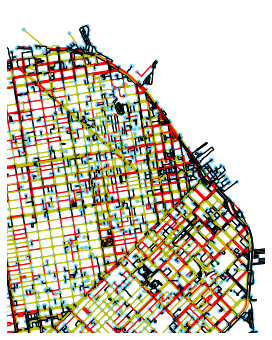

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f19eaacaa90>)

In [ ]:
#Generate Heatmap
risky = nx.get_edge_attributes(G, 'risk3')
ec = []
for riskyness in risky.values():
  if riskyness < 1.7:
    ec.append('g')
  elif riskyness == 5.1:
    ec.append('k')
  elif 1.7 <= riskyness <= 3.4:
    ec.append('y')
  else:
    ec.append('r')
ox.plot.plot_graph(G, bbox=box, edge_color=ec)

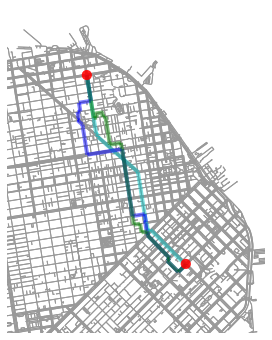

In [ ]:
#Graphing the routes
fig1, ax1 = ox.plot_graph_routes(G, [route, route2, route3], bbox = box, route_color=rc, node_size=0)


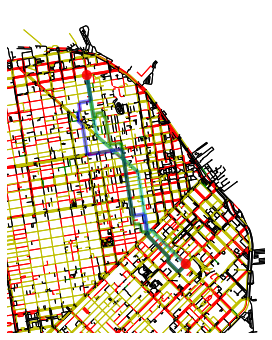

In [ ]:
#Routes over "heat map" of crime data
fig1, ax1 = ox.plot_graph_routes(G, [route, route2, route3], bbox = box, route_color=rc, node_size=0, edge_color=ec)

In [ ]:
#The ideal route based on length - Distance in miles and safety level in both forms
def prodRoute(origin, destination, weightType):
  route = nx.shortest_path(G, origin, destination, weight=weightType)
  distance = 0
  safe = 0
  safe2 = 0
  for index in range(len(route)-1):
    distance += nx.shortest_path_length(G, route[index], route[index+1], weight='length')
    safe += nx.shortest_path_length(G, route[index], route[index+1], weight='risk')
    safe2 += nx.shortest_path_length(G, route[index], route[index+1], weight='risk3')
  return(round(distance*0.000621371, 3), safe, safe2, route)

In [ ]:
#Results table on test data:

Data_Table = pd.DataFrame(columns = ["Path", "Length Distance", "Length KNN Risk", "Length Radial Risk", "KNN Distance", 
                                     "KNN risk", "KNN Radial Risk", "Radial Distance", "Radial KNN Risk", "Radial Risk", 
                                     "Length Route", "KNN Route", "Radial Route"])

CalTrain_Station = (37.776749, -122.394714); MOMA = (37.785633, -122.401181); Botannical_Gardens = (37.766907, -122.466606); SF_Zoo = (37.735353, -122.503082)
Twin_Peaks = (37.754125, -122.447159); Lombard = (37.802006, -122.419601); Coit_Tower = (37.802796, -122.405862); Peir_39 = (37.808431, -122.410164)
Ghirradelli = (37.806365, -122.422303); Beach = (37.774978, -122.511664); CCSF = (37.725772, -122.452453)

TestPoints = [('CalTrain_Station', CalTrain_Station), ('MOMA',MOMA), ('Botannical_Gardens', Botannical_Gardens), 
              ('SF_Zoo', SF_Zoo), ('Twin_Peaks', Twin_Peaks), ('Lombard', Lombard), ('Coit_Tower', Coit_Tower), 
              ('Peir_39',Peir_39), ('Ghirradelli',Ghirradelli), ('Beach',Beach), ('CCSF',CCSF)]

for origin in TestPoints:
  for destination in TestPoints:
    if origin != destination:
      startNode = ox.get_nearest_node(G, origin[1], method='euclidean')
      endNode = ox.get_nearest_node(G, destination[1], method='euclidean')
      dist,knn, rrisk, route = prodRoute(startNode, endNode, 'length')
      dist2,knn2, rrisk2, route2 = prodRoute(startNode, endNode, 'risk')
      dist3,knn3, rrisk3, route3 = prodRoute(startNode, endNode, 'risk3')
      Data_Table = Data_Table.append({"Path":origin[0] + "->" + destination[0], 
                         "Length Distance": dist, "Length KNN Risk": knn, "Length Radial Risk": rrisk, 
                         "KNN Distance":dist2, "KNN risk":knn2, "KNN Radial Risk":rrisk2, 
                         "Radial Distance":dist3, "Radial KNN Risk":knn3, "Radial Risk":rrisk3,
                         "Length Route":route, "KNN Route": route2, "Radial Route":route3}, ignore_index=True)
      
Data_Table.set_index("Path")
Data_Table




,Path,Length Distance,Length KNN Risk,Length Radial Risk,KNN Distance,KNN risk,KNN Radial Risk,Radial Distance,Radial KNN Risk,Radial Risk,Length Route,KNN Route,Radial Route
0,CalTrain_Station->MOMA,0.853,158.0,171.320784,1.197,105.0,142.317457,0.873,121.0,123.880573,"[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523..."
1,CalTrain_Station->Botannical_Gardens,4.297,490.0,512.805265,4.997,333.0,367.195777,4.837,348.0,347.760325,"[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523..."
2,CalTrain_Station->SF_Zoo,7.535,703.0,801.644985,10.326,409.0,582.120531,9.065,507.0,499.386006,"[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523..."
3,CalTrain_Station->Twin_Peaks,3.914,416.0,483.873069,4.946,286.0,347.108146,4.593,310.0,319.411066,"[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523..."
4,CalTrain_Station->Lombard,2.529,391.0,463.602903,3.556,217.0,301.680802,4.352,264.0,258.245250,"[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523...","[3532718855, 7044465269, 7044465248, 704446523..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,CCSF->Lombard,6.579,797.0,949.769880,10.104,373.0,566.489800,9.102,428.0,433.914916,"[1712523168, 1711296773, 65324690, 3112173481,...","[1712523168, 1711296773, 1711297018, 563968131...","[1712523168, 1711296773, 1711297018, 563968131..."
106,CCSF->Coit_Tower,6.917,721.0,858.046081,10.807,402.0,632.432042,9.798,466.0,489.735635,"[1712523168, 1711296773, 65324690, 3112173481,...","[1712523168, 1711296773, 1711297018, 563968131...","[1712523168, 1711296773, 1711297018, 563968131..."
107,CCSF->Peir_39,7.264,838.0,1022.818657,11.231,444.0,706.227634,10.268,530.0,540.370109,"[1712523168, 1711296773, 65324690, 3112173481,...","[1712523168, 1711296773, 1711297018, 563968131...","[1712523168, 1711296773, 1711297018, 563968131..."
108,CCSF->Ghirradelli,6.897,736.0,857.426316,10.329,395.0,595.466150,9.328,452.0,460.557864,"[1712523168, 1711296773, 65324690, 3112173481,...","[1712523168, 1711296773, 1711297018, 563968131...","[1712523168, 1711296773, 1711297018, 563968131..."


Resources: \\
Link to Crime Data Visualization: https://data.sfgov.org/d/tmnf-yvry/visualization

